### Find latent features in Place cells using Matrioshka SAEs

Main goal: look at different levels of features in a 3-level MSAE

Steps:

1. Train MSAE on spikes dataset

2. Create (topk) sae feature df

3. Create stim (meta)data df

4. Interp / autointerp
    
    a. Create infra for finding stim at times of particular feature(s)
    
    b. Create infra for finding topk SAE features that fire at times of particular stim

In [19]:
"""Import packages."""

import math
from collections import defaultdict
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Callable, List, Optional, Tuple

# import jax
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from IPython.display import HTML
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from rich import print as rprint
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
from torch import bfloat16, nn, Tensor
from torch.nn import functional as F
from torcheval.metrics.functional import r2_score as tm_r2_score
from tqdm.notebook import tqdm

from mini import train as mt
from mini.util import vec_r2

In [20]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Load simulated place cells spike matrix (this matrix has data from 4 simulated place cells and 96 random cells - aka noise)

spike_matrix = np.load("/place-cell-simulations/spike_matrix.npy")

print(spike_matrix.shape) 

(100, 300000)


In [22]:
# We want it the other way around, neurons = columns and rows = timepoints

spike_matrix = spike_matrix.T

print(spike_matrix.shape)

(300000, 100)


### Train MSAE

In [23]:
dsae_topk_map = {128: 4, 256: 8, 512: 16}
dsae_topk_map = dict(sorted(dsae_topk_map.items()))  # ensure sorted from smallest to largest
dsae_loss_x_map = {128: 1, 256: 1.25, 512: 1.5}
dsae_loss_x_map = dict(sorted(dsae_loss_x_map.items()))
dsae = max(dsae_topk_map.keys())
n_inst = 2

In [24]:
# gonna want a gpu if training! not necessary if loading saved features from a trained model
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"{device=}")

device=device(type='cuda')


In [25]:
# convert to torch tensor and normalize spike counts

spike_cts = t.from_numpy(spike_matrix).bfloat16().to(device)
spike_cts /= spike_cts.max()

In [26]:
sae_cfg = mt.SaeConfig(
    n_input_ae=spike_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-4

n_epochs = 2
batch_sz = 16
n_steps = spike_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spike_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

SAE batch training step: 100%|██████████| 37500/37500 [07:37<00:00, 81.98it/s, loss=0.00227,  l0_mean=16.0, l0_std=18.139245986938477, frac_dead=0.802734375] 


## Validate SAEs

In [27]:
"""Check for nans in weights."""

sae.W_dec.isnan().sum(), sae.W_enc.isnan().sum()

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

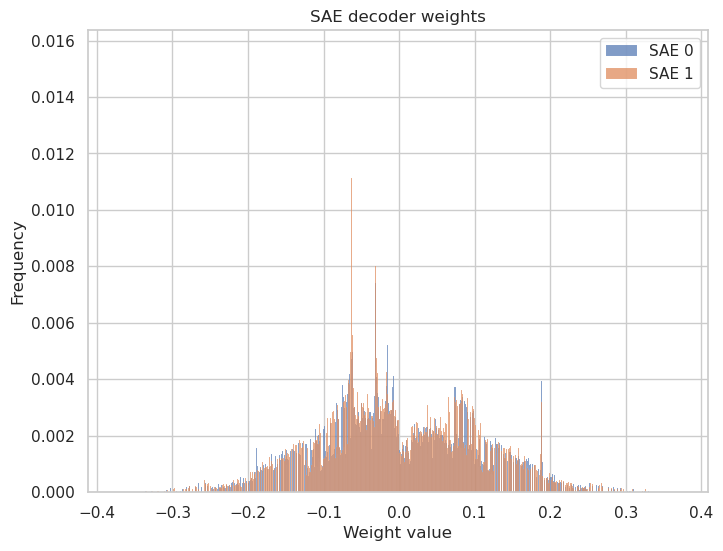

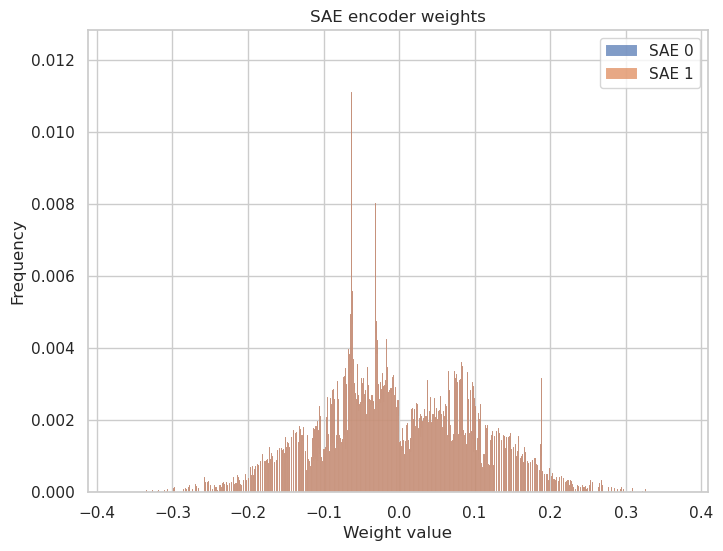

In [28]:
"""Visualize weights."""

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sae.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_enc_flat = asnumpy(sae.W_enc[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE encoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

SAE batch evaluation step:   0%|          | 0/18750 [00:00<?, ?it/s]

SAE batch evaluation step: 100%|██████████| 18750/18750 [00:28<00:00, 649.67it/s]


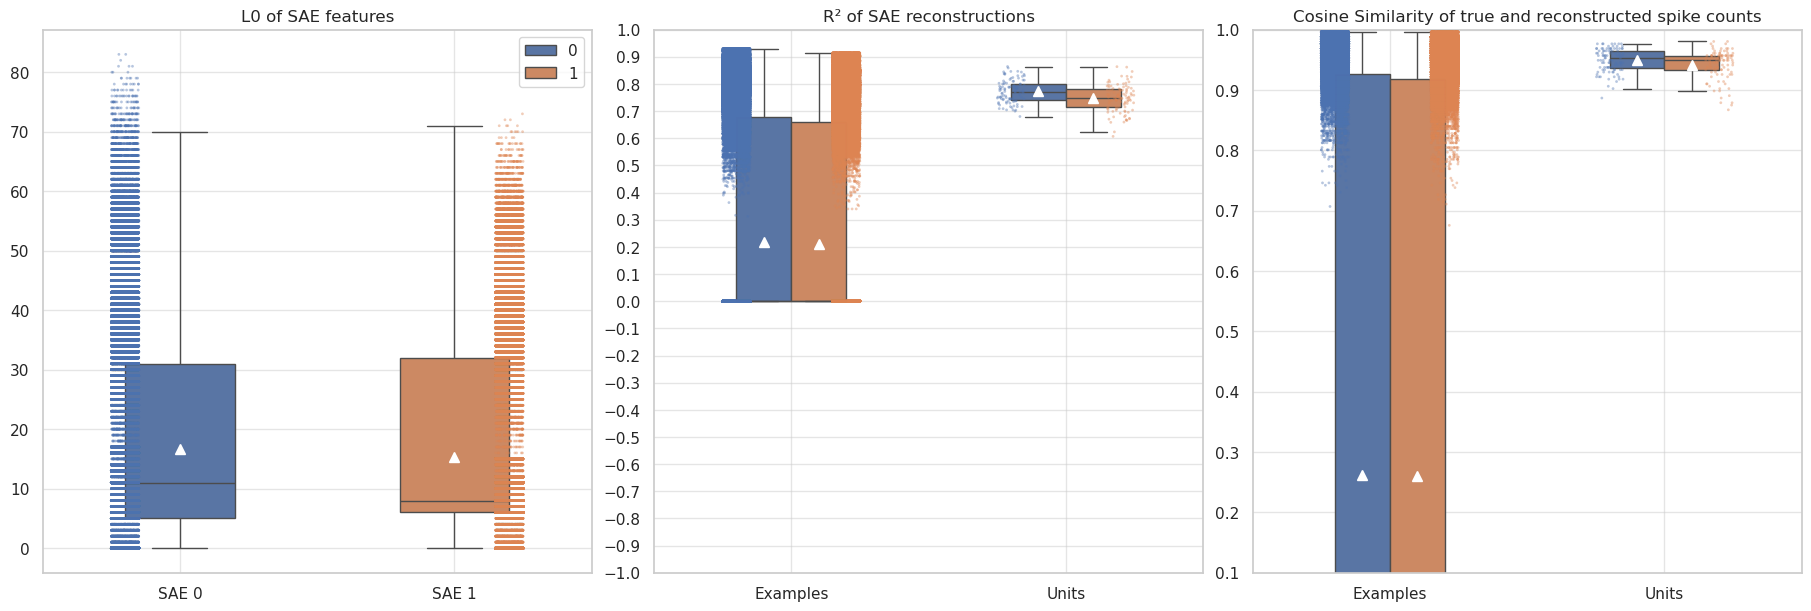

In [29]:
"""Visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spike_cts, sae, batch_sz=batch_sz)

In [30]:
"""Calculate variance explained of summed spike counts."""

# Var explained for summed spike counts.
n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spike_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")

SAE instance 0 R² (summed spike count over all units per example) = 0.929
SAE instance 1 R² (summed spike count over all units per example) = 0.913


## Remove bad units and retrain

In [31]:
"""Re-train."""

r2_thresh = 0.1
inst = 0
r2_per_unit = r2_per_unit[:, inst]
keep_mask = r2_per_unit > r2_thresh
print(f"frac units above {r2_thresh=}: {keep_mask.sum() / keep_mask.shape[0]:.2f}")
print(f"Number to keep: {keep_mask.sum()} / {keep_mask.shape[0]}")

# Remove units and retrain
spk_cts = spike_cts[:, keep_mask]

sae_cfg = mt.SaeConfig(
    n_input_ae=spk_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-4

n_epochs = 20
batch_sz = 16
n_steps = spk_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spk_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

frac units above r2_thresh=0.1: 1.00
Number to keep: 100 / 100


SAE batch training step:   0%|          | 0/375000 [00:00<?, ?it/s, loss=0.00610,  l0_mean=16.0, l0_std=25.544395446777344, frac_dead=0.0]

SAE batch training step:  38%|███▊      | 141633/375000 [31:11<51:23, 75.68it/s, loss=0.00128,  l0_mean=16.0, l0_std=11.227845191955566, frac_dead=0.64453125]    


KeyboardInterrupt: 

SAE batch evaluation step: 100%|██████████| 292/292 [00:00<00:00, 495.05it/s]


SAE instance 0 R² (summed spike count over all units per example) = 0.999
SAE instance 1 R² (summed spike count over all units per example) = 0.999


/root/mini/.pixi/envs/default/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


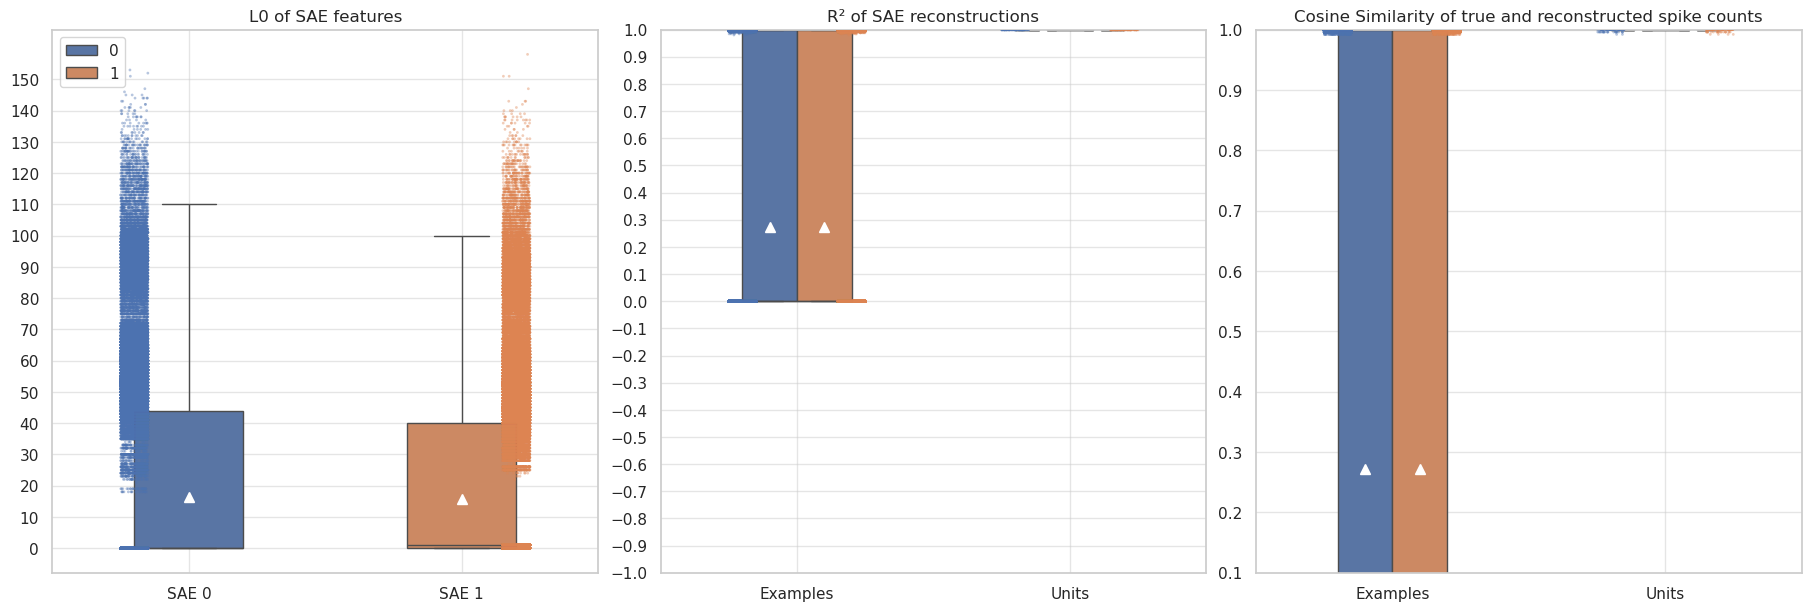

In [ ]:
"""Re-visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spk_cts, sae, batch_sz=batch_sz)

n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")


In [ ]:
"""

save_spk_cts = True
session_id = "30-08-2025_19_47_55"  # change to your session id

if save_spk_cts:
    # Save the spike counts to a CSV file
    out_dir = Path("/root/place-cell-simulations")
    save_path = out_dir / f"{session_id}_spike_counts.csv"
    spk_cts_df = pd.DataFrame(spike_matrix)
    spk_cts_df_new = pd.DataFrame(asnumpy(spk_cts.float()))
    spk_cts_df_new.columns = spk_cts_df.columns[keep_mask]
    spk_cts_df = spk_cts_df_new
    display(spk_cts_df)
    spk_cts_df.to_csv(save_path, index=False)
    print(f"Spike counts saved to {save_path}")"""

,0,1,2,3,4,5,6,7,8,9,10,11,...,88,89,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


OSError: Cannot save file into a non-existent directory: '/root/place-cell-simulations/30-08-2025_19_47_55'

## Interpret features

In [ ]:

out_dir = Path("/workspace/SAE_place_cells/")
session_id = "31-08-2025_12_47_55"  # change to your session id

load_acts = False  # if True, will load saved feature activations
save_acts = False
sae_datafile = "sae_0.csv"  # set name of data file to load (or save to)

acts_df_save_path = out_dir / f"{session_id}" / "sae_features" / sae_datafile
acts_df_save_path.parent.mkdir(parents=True, exist_ok=True)

In [ ]:
"""Create dfs of feature activations."""

if not load_acts:

    # Convert tensor to numpy array for easier handling
    acts_array = asnumpy(topk_acts_4d)

    # Create DataFrame with the data
    acts_df = pd.DataFrame({
        "example_idx": acts_array[:, 0],
        "instance_idx": acts_array[:, 1],
        "feature_idx": acts_array[:, 2],
        "activation_value": acts_array[:, 3]
    })

    # Convert appropriate cols to ints
    acts_df["example_idx"] = acts_df["example_idx"].astype(int)
    acts_df["feature_idx"] = acts_df["feature_idx"].astype(int)
    acts_df["instance_idx"] = acts_df["instance_idx"].astype(int)

    n_recon_examples = int(acts_df.iloc[-1]["example_idx"]) + 1

In [ ]:
"""Create df with info per feature."""

# Get a features df from acts df
features_df = acts_df.groupby(["instance_idx", "feature_idx"]).agg(
    activation_mean=("activation_value", "mean"),
    activation_std=("activation_value", "std"),
    activation_count=("activation_value", "count")
).reset_index()
features_df["act_mean_over_std"] = features_df["activation_mean"] / features_df["activation_std"]
features_df["activation_frac"] = features_df["activation_count"] / n_recon_examples
features_df = features_df.drop(columns=["activation_count"])
features_df = features_df.dropna().reset_index(drop=True)

if not load_acts:
    # Keep only features from features_df in acts_df
    acts_df = acts_df[acts_df["feature_idx"].isin(features_df["feature_idx"])].reset_index(drop=True)

if save_acts:
    acts_df.to_csv(acts_df_save_path, index=False)

In [ ]:
display(acts_df)
display(features_df)

In [ ]:
len(features_df[features_df["instance_idx"] == 1])

In [ ]:
"""Compare features from ("broad" or "general") and ("specific" or "nested") levels."""

last_feat_idx_general = list(dsae_topk_map.keys())[0]
first_feat_idx_specific = list(dsae_topk_map.keys())[1]

print(features_df[features_df["feature_idx"] < last_feat_idx_general]["activation_frac"].describe())
print()
print(features_df[np.logical_and(
    features_df["feature_idx"] > last_feat_idx_general,
    features_df["feature_idx"] < first_feat_idx_specific
)]["activation_frac"].describe())
print()
print(features_df[features_df["feature_idx"] > first_feat_idx_specific]["activation_frac"].describe())

In [ ]:
"""Visualize feature info"""

# top_n = dsae
# top_features = features_df.nlargest(top_n, "activation_count")
# plot_df = acts_df[acts_df["feature_idx"].isin(top_features["feature_idx"].tolist())]

# fig, ax = plt.subplots(figsize=(14, 8))
# sns.boxplot(x="feature_idx", y="activation_value", data=plot_df, showfliers=False, ax=ax)
# ax.set_title(f"Distributions of activation values for top {top_n} features")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Activation Value")
# ax.tick_params(axis="x", rotation=45)
# fig.tight_layout()

# # Barplot of "feature on" counts
# fig, ax = plt.subplots(figsize=(14, 8))
# sns.barplot(x="feature_idx", y="activation_frac", data=features_df, ax=ax)
# ax.set_title(f"Feature activation count for top {top_n} features")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Activation Count")
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# # ax.set_ylim(0, 0.01)
# ax.tick_params(axis="x", rotation=45)
# fig.tight_layout()

## Filter features by different properties

In [ ]:
"""Filter features by time active."""

tot_s = n_recon_examples * bin_s  
min_s_act = 5000
max_s_act = 10000
min_frac_act = min_s_act / tot_s
max_frac_act = max_s_act / tot_s
features_df = features_df[
    (features_df["activation_frac"] >= min_frac_act)
    & (features_df["activation_frac"] <= max_frac_act)
].reset_index(drop=True)

In [ ]:
pd.set_option("display.max_rows", 25)
features_df.sort_values("activation_mean", ascending=True)

In [ ]:
features_df.sort_values("activation_std", ascending=True)

In [ ]:
features_df.sort_values("act_mean_over_std", ascending=False)

In [ ]:
features_df.sort_values("activation_frac", ascending=True)

In [ ]:
features_df = features_df[features_df["instance_idx"] == 1]
features_df = features_df.nlargest(200, "activation_frac")

## Hunt for features

In [ ]:
features_df[features_df["activation_frac"] < 0.1].sort_values("act_mean_over_std", ascending=False).head(20)

In [ ]:
features_df[features_df["feature_idx"] > last_feat_idx_general].sort_values("activation_frac", ascending=True).head(10)

In [ ]:
"""For a particular feature, get times it fired + stim deta at these times."""

inst_i, feat_i = 1, 1015
f_ex_idxs = acts_df[
    np.logical_and(acts_df["instance_idx"] == inst_i, acts_df["feature_idx"] == feat_i)
]["example_idx"].values
print(f_ex_idxs.shape)
feat_metadata = metadata.loc[f_ex_idxs]
display(feat_metadata)